In [63]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import os
import pickle
import seaborn as sns

from numpy import arccos as acos
from numpy import arctan2 as atan2
from numpy import arcsin as asin
from numpy import sin, cos, tan
from tqdm import tqdm
from time import time

def string_time_to_decimal_degrees(time_str):
    if time_str[0] == '-':
        sign = -1
        time_str = time_str[1:]
    else:
        sign = 1
    t = datetime.time(*[int(x) for x in time_str.split('.')[0].split(':')])
    ts = sign * (t.hour * 3600 + t.minute * 60 + t.second) / 3600. * 15
    return ts

def angular_difference(a, b):
    angular_difference = np.abs(a - b)
    angular_difference = np.where(angular_difference >= 180.0,
                                  360.0 - angular_difference,
                                  angular_difference)
    if a < b:
        angular_difference *= -1
    return angular_difference
    
def calculateLST(longitude_deg, t):
    """
    midnight = floor(2458484.833333) + 0.5            // J0 = 2458484.5
    days_since_midnight = 2458484.833333 - 2458484.5  // = 0.333333
    hours_since_midnight = 0.333333 * 24              // H = 8.0
    days_since_epoch = 2458484.833333 - 2451545.0     // D = 6939.833333
    centuries_since_epoch = days_since_epoch / 36525  // T = 0.190002
    whole_days_since_epoch = 2458484.5 - 2451545.0    // D0 = 6939.5

    GMST = 6.697374558 
        + 0.06570982441908 * whole_days_since_epoch 
        + 1.00273790935 * hours_since_midnight
        + 0.000026 * centuries_since_epoch**2        //=470.712605328

    GMST_hours = 470 % 24 // = 14
    GMST_minutes =  floor(0.712605328 * 60) //=42(.7563197)
    GMST_seconds =  0.7563197*60 // =45.38"""
    H = t.hour
    minute = t.minute
    JDTT = computeJulianDate(t.year, t.month, t.day, H)
    JD0 = computeJulianDate(t.year, t.month, t.day, 0.0)
    DTT = JDTT - 2451545.0
    DUT = JD0 - 2451545.0
    T = DTT / 36525.0
    left = 6.697375 + 0.065707485828*DUT + 1.0027379*H + 0.0854103*T + 0.0000258*T**2
    right = 24
    GMST = (left + minute/60) % right #trial to improve accuracy along one hour
    localSiderealTime = GMST + longitude_deg / 15.0
    return localSiderealTime


# Function to compute the Julian Date for a given date
def computeJulianDate(year, month, day, UT):
    if (month <= 2):
        year -= 1;
        month += 12;

    A = np.floor(year / 100);
    B = 2 - A + np.floor(A / 4);

    JD = np.floor(365.25 * (year + 4716)) + np.floor(30.6001 * (month + 1)) + day + B - 1524.5 + UT / 24.0;
    return JD


#Converts Alt/Az to Hour Angle and Declination
#Modified from Meeus so that 0 Az is North
#All angles are in radians
# https://www.astrogreg.com/snippets/altaztoHAdec.html
def altAzToHA(lat, alt, az):
    H=atan2(-sin(az),tan(alt)*cos(lat)-cos(az)*sin(lat));
    #if(H<0):
    #    H+=np.PI*2
    return H


def altAzTodec(lat, alt, az):
    dec=asin(sin(lat)*sin(alt) + cos(lat)*cos(alt)*cos(az));
    return dec;

def arduino_rad_dec(lat, pitch, yaw, current_t):
    #Compute the observer's direction in Altitude-Azimuth coordinates
    alt_rad = pitch
    az_rad = yaw
    #phi : latitude, a : alt, A : az, ST : lst_hours, delta : declination, alpha : right ascension

    #Calculate the observer's declination in radians
    #float sindeclination_rad = sin(lat*np.deg2rad)*sin(alt_rad) + cos(lat*np.deg2rad)*cos(alt_rad)*cos(az_rad);
    #float declination_rad = asin(sindeclination_rad);
    #float sinhour_angle_rad = -sin(az_rad)*cos(alt_rad) / cos(declination_rad);*/
    declination_rad = altAzTodec(np.deg2rad(lat), alt_rad, az_rad)


    # Calculate the Local Sidereal Time (LST) in hours
    lst_hours = calculateLST(lon, current_t)

    #lst_hours = 297.92 / 15;
    # Calculate the observer's right ascension in radians
    #hour_angle_rad = acos((sin(alt_rad) - sin(np.deg2rad(lat))*sin(declination_rad))/(cos(np.deg2rad(lat))*cos(declination_rad)))
    hour_angle_rad = altAzToHA(np.deg2rad(lat), alt_rad, az_rad), 

    right_ascension_rad = np.deg2rad(lst_hours*15) - hour_angle_rad

    # Convert right ascension and declination from radians to degrees
    right_ascension_deg = np.rad2deg(right_ascension_rad)
    declination_deg = np.rad2deg(declination_rad)
    right_ascension_deg = right_ascension_deg % 360.0
    # Wrap angles to the range [0, 360) degrees
    if (right_ascension_deg < 0):
        right_ascension_deg += 360.0
    return alt_rad, az_rad, declination_rad, lst_hours, hour_angle_rad, right_ascension_deg, declination_deg

def compute_ra_dec(latitude_deg, longitude_deg, time_utc, pitch_deg, roll_deg, yaw_deg):
    # Convert degrees to radians for pitch, roll, and yaw
    pitch_rad = pitch_deg * u.deg
    yaw_rad = yaw_deg * u.deg

    # Observer's location
    observer_location = EarthLocation(lon=longitude_deg * u.deg, lat=latitude_deg * u.deg)

    # Convert time string to astropy Time object
    time = Time(time_utc)

    # Compute the observer's direction in Altitude-Azimuth coordinates
    alt = pitch_rad#np.arcsin(np.sin(pitch_rad) * np.sin(roll_rad))
    az = yaw_rad#np.arctan2(np.sin(roll_rad), np.cos(roll_rad) * np.sin(pitch_rad))
    # Convert observer's direction to equatorial coordinates (RA and Dec)
    altaz_coord = SkyCoord(az=az, alt=alt, obstime=time, location=observer_location, frame='altaz')
    icrs_coord = altaz_coord.transform_to(ICRS)

    # Get the right ascension and declination in degrees
    ra = icrs_coord.ra.deg
    dec = icrs_coord.dec.deg

    # Define the date and time for which you want to compute GMST


    # Calculate the Greenwich Mean Sidereal Time (GMST) at the given time and location
    lmst = time.sidereal_time('mean', longitude=observer_location.lon)
    lmsts = string_time_to_decimal_degrees(lmst.to_string(unit=u.hourangle, sep=':', pad=True))
    HA = (lmst - icrs_coord.ra)
    has = string_time_to_decimal_degrees(HA.to_string(unit=u.hourangle, sep=':', pad=True))
    return ra, dec, lmst, icrs_coord, has, lmsts

# Example usage:


roll_deg = 0      # Roll angle in degrees
Second = 36

pitch_deg = 0.5    # Pitch angle in degrees
yaw_deg = 85.3     # Yaw angle in degrees
Day   =     4
Month  =      8
Year  =   2023
Hour   =      10
Minute  =     00

lat = 45.665359  # Latitude of the observer in degrees
lon = 3.100794 # Longitude of the observer in degrees
pitch = np.deg2rad(pitch_deg)   # Pitch angle in degrees
roll = np.deg2rad(roll_deg)     # Roll angle in degrees
yaw = np.deg2rad(yaw_deg)    # Yaw angle in degrees




#setTime(Hour, Minute, Second, Day, Month, Year);
current_t = pd.Timestamp(f'{Year:d}-{Month:d}-{Day:d} {Hour:d}:{Minute:d}:{Second:d}')
time_utc = str(current_t)

t0 = time()
ra, dec, lmst, coord, HA, LMST = compute_ra_dec(lat, lon, time_utc, pitch_deg, roll_deg, yaw_deg)
print("Time with astropy: {}".format(time() - t0))

t0 = time()
alt_rad, az_rad, declination_rad, lst_hours, hour_angle_rad, right_ascension_deg, declination_deg = arduino_rad_dec(lat, pitch, yaw, current_t)
print("Time with custom: {}".format(time() - t0))

ra_error = angular_difference(ra, right_ascension_deg)
dec_error = angular_difference(dec, declination_deg)

print('declination (astropy/arduino/error)')
print(dec, declination_deg, dec_error)
print('ra (astropy/arduino/error)')
print(ra, right_ascension_deg, ra_error)
print('local sidereal time (astropy/arduino/error)')
print(LMST, lst_hours*15, angular_difference(lst_hours*15, LMST))
print('HA (astropy/arduino/error)')
print(HA, np.rad2deg(hour_angle_rad), angular_difference(HA, np.rad2deg(hour_angle_rad)))

Time with astropy: 0.005000591278076172
Time with custom: 0.000499725341796875
declination (astropy/arduino/error)
3.7632162851512465 3.6408580288228776 0.12235825632836894
ra (astropy/arduino/error)
198.68555643260873 [198.83293162] [-0.14737519]
local sidereal time (astropy/arduino/error)
105.96666666666667 105.81700054365392 -0.14966612301275006
HA (astropy/arduino/error)
-92.71666666666667 [-93.01593108] [0.29926441]


In [27]:
pitch_range = np.linspace(0, 90, 10)
yaw_range = np.linspace(0, 360, 20)
days_range = [15]#np.arange(30)+1
month_range = [8]#[8, 9, 10, 11]
year_range = [2023] #[2021, 2022]
hour_range = np.concatenate([np.arange(5), np.arange(20, 24)])
min_range = np.arange(0, 60, 10)

In [34]:
if os.path.isfile('../logs/ra_dec_performance.pkl'):
    result = pickle.load(open('../logs/ra_dec_performance.pkl', 'rb'))
    print("Results loaded")
else:
    result = {}
    for pitch_deg in tqdm(pitch_range):
        for yaw_deg in yaw_range:
            for Day in days_range:
                for Month in month_range:
                    for Year in year_range:
                        for Hour in hour_range:
                            for Minute in min_range:
                                pitch = np.deg2rad(pitch_deg)   # Pitch angle in degrees
                                roll = np.deg2rad(roll_deg)     # Roll angle in degrees
                                yaw = np.deg2rad(yaw_deg)    # Yaw angle in degrees
                                Second = 0

                                #setTime(Hour, Minute, Second, Day, Month, Year);
                                current_t = pd.Timestamp(f'{Year:d}-{Month:d}-{Day:d} {Hour:d}:{Minute:d}:{Second:d}')
                                time_utc = str(current_t)

                                ra, dec, lmst, coord, HA, LMST = compute_ra_dec(lat, lon, time_utc, pitch_deg, roll_deg, yaw_deg)

                                alt_rad, az_rad, declination_rad, lst_hours, hour_angle_rad, right_ascension_deg, declination_deg = arduino_rad_dec(lat, pitch, yaw, current_t)

                                ra_error = float(angular_difference(ra, right_ascension_deg))
                                dec_error = float(angular_difference(dec, declination_deg))
                                result[(pitch_deg, yaw_deg, Day, Month, Year, Hour, Minute)] = [ra_error, dec_error]
    pickle.dump(result, open('../logs/ra_dec_performance.pkl', 'wb'))

100%|██████████| 10/10 [00:49<00:00,  4.97s/it]


In [35]:
df = pd.DataFrame.from_dict(result)

In [36]:
df = df.T

In [37]:
df.index.names = ['pitch_deg', 'yaw_deg', 'Day', 'Month', 'Year', 'Hour', 'Minute']

In [38]:
df.columns = ['ra_error', 'dec_error']

In [39]:
df.reset_index(inplace=True)

# Overall angular error

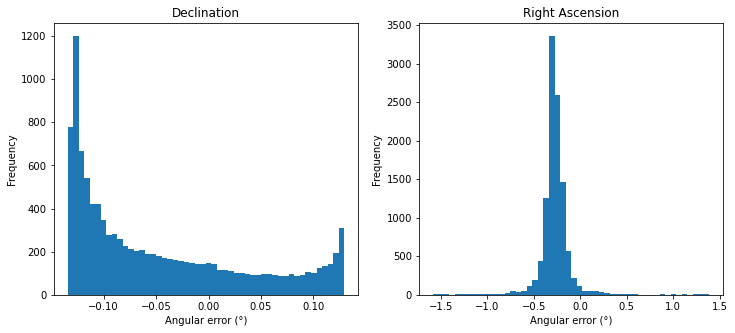

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df.dec_error.plot(kind='hist', bins=50, ax=ax[0])
ax[0].set_title('Declination')
df.ra_error.plot(kind='hist', bins=50, ax=ax[1])
ax[1].set_title('Right Ascension')
for a in ax:
    a.set_xlabel('Angular error (°)')

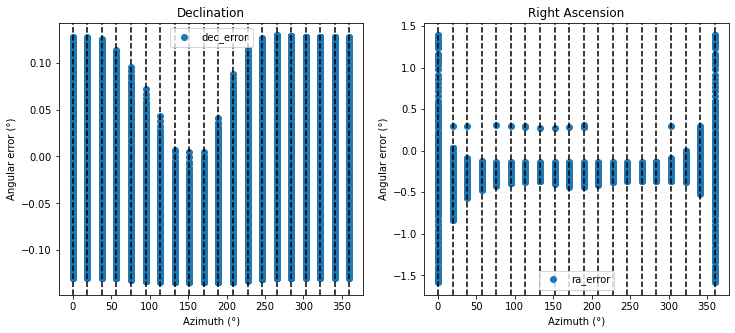

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df.plot(x='yaw_deg', y='dec_error', linestyle='', marker='o', ax=ax[0])
ax[0].set_title('Declination')
df.plot(x='yaw_deg', y='ra_error', linestyle='', marker='o', ax=ax[1])
ax[1].set_title('Right Ascension')
for a in ax:
    for p in yaw_range:
        a.axvline(p, linestyle='dashed', color='k')
        a.set_ylabel('Angular error (°)')
        a.set_xlabel('Azimuth (°)')

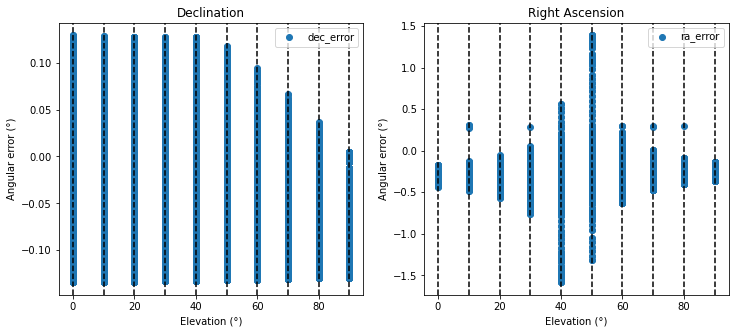

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df.plot(x='pitch_deg', y='dec_error', linestyle='', marker='o', ax=ax[0])
ax[0].set_title('Declination')
df.plot(x='pitch_deg', y='ra_error', linestyle='', marker='o', ax=ax[1])
ax[1].set_title('Right Ascension')
for a in ax:
    for p in pitch_range:
        a.axvline(p, linestyle='dashed', color='k')
        a.set_ylabel('Angular error (°)')
        a.set_xlabel('Elevation (°)')

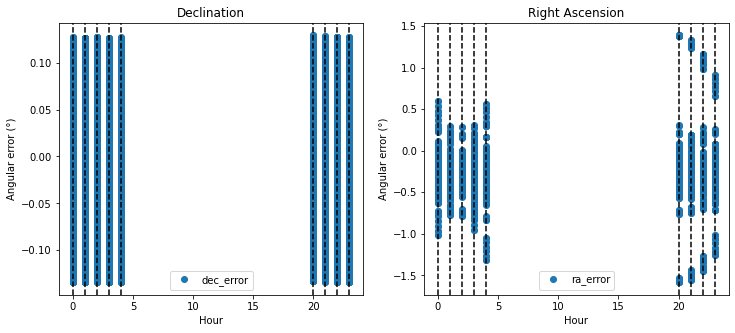

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df.plot(x='Hour', y='dec_error', linestyle='', marker='o', ax=ax[0])
ax[0].set_title('Declination')
df.plot(x='Hour', y='ra_error', linestyle='', marker='o', ax=ax[1])
ax[1].set_title('Right Ascension')
for a in ax:
    for p in hour_range:
        a.axvline(p, linestyle='dashed', color='k')
        a.set_ylabel('Angular error (°)')
        a.set_xlabel('Hour')

Next guess was the hour, due to julian date approximation with 4bits float

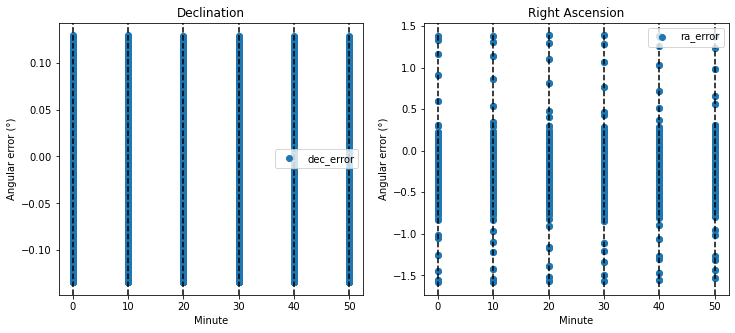

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df.plot(x='Minute', y='dec_error', linestyle='', marker='o', ax=ax[0])
ax[0].set_title('Declination')
df.plot(x='Minute', y='ra_error', linestyle='', marker='o', ax=ax[1])
ax[1].set_title('Right Ascension')
for a in ax:
    for p in min_range:
        a.axvline(p, linestyle='dashed', color='k')
        a.set_ylabel('Angular error (°)')
        a.set_xlabel('Minute')

In [79]:
data = df.groupby(['yaw_deg', 'pitch_deg']).ra_error.agg('median').to_frame().reset_index()

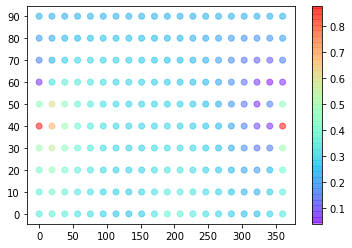

In [81]:
plt.scatter(data.yaw_deg, data.pitch_deg, c=data.ra_error.abs(), alpha=0.5, cmap=plt.get_cmap('rainbow'))
plt.colorbar()
plt.yticks(pitch_range);